# Mesoscale Convective System (MCS) Tracking Notebook

This notebook implements the MCS tracking workflow using PyFLEXTRKR. It breaks down the process into distinct steps:

1. Identify cloud and precipitation features
2. Link features in time-adjacent files
3. Track features through the entire dataset
4. Calculate track statistics
5. Identify MCS using brightness temperature (Tb)
6. Match precipitation features (PF) to MCS
7. Identify robust MCS using both criteria
8. Map tracking results to pixel files
9. Calculate movement speed
10. Remap MCS mask to HEALPix grid

Each step can be run independently by setting the appropriate configuration flags.

Author:
- Zhe Feng (<zhe.feng@pnnl.gov>)

### Instructions for running PyFLEXTRKR

PyFLEXTRKR is designed to be run on the command line. More detailed instructions is available [here](https://github.com/FlexTRKR/PyFLEXTRKR?tab=readme-ov-file#5-running-pyflextrkr).

To run PyFLEXTRKR on the command line:

```bash
python run_mcs_tbpf_mcsmip.py config_file.yml
```

This notebook is for demonstration purpose to show each of the steps, with a simple visualization after running the tracking. The example uses the SCREAM simulation outputs converted to HEALPix format for [The Digital Earths Global Hackathon](https://github.com/digital-earths-global-hackathon).

## Import Libraries and Setup Logging

First, we'll import all necessary libraries and set up logging for the MCS tracking process.

In [1]:
import os
# import sys
import logging
import dask
from dask.distributed import Client, LocalCluster
# import yaml
import xarray as xr
import pandas as pd
import numpy as np
import warnings
import easygems.healpix as egh
import matplotlib.pyplot as plt

# Import PyFLEXTRKR modules
from pyflextrkr.ft_utilities import load_config, setup_logging
from pyflextrkr.idfeature_driver import idfeature_driver
from pyflextrkr.tracksingle_driver import tracksingle_driver
from pyflextrkr.gettracks import gettracknumbers
from pyflextrkr.trackstats_driver import trackstats_driver
from pyflextrkr.identifymcs import identifymcs_tb
from pyflextrkr.matchtbpf_driver import match_tbpf_tracks
from pyflextrkr.robustmcspf_saag import define_robust_mcs_pf
from pyflextrkr.mapfeature_driver import mapfeature_driver
from pyflextrkr.movement_speed import movement_speed
from pyflextrkr.remap_healpix_zarr import remap_to_healpix_zarr

# Set up logging
setup_logging()
logger = logging.getLogger(__name__)

# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Load Configuration
We'll load the YAML configuration file for the MCS tracking.

You can download the example config file from the PyFLEXTRKR repository using [this link](https://raw.githubusercontent.com/FlexTRKR/PyFLEXTRKR/main/config/config_mcs_tbpf_scream_healpix7.yml).


In [2]:
# Specify the configuration file path
config_file = "/global/homes/f/feng045/program/PyFLEXTRKR-dev/config/config_mcs_tbpf_scream_healpix7.yml"

In [3]:
# Load configuration
config = load_config(config_file)
print(f"Successfully loaded configuration from: {config_file}")

# Specify track statistics file basename and pixel-level output directory
# for mapping track numbers to pixel files
trackstats_filebase = config['trackstats_filebase']  # All Tb tracks
mcstbstats_filebase = config['mcstbstats_filebase']  # MCS tracks defined by Tb-only
mcsrobust_filebase = config['mcsrobust_filebase']   # MCS tracks defined by Tb+PF
mcstbmap_outpath = 'mcstracking_tb'     # Output directory for Tb-only MCS
alltrackmap_outpath = 'ccstracking'     # Output directory for all Tb tracks

# Return the config and show key parameters
print("\nKey Parameters:")
print(f"Start Date: {config.get('startdate', 'Not specified')}")
print(f"End Date: {config.get('enddate', 'Not specified')}")
print(f"Parallel Processing: {config.get('run_parallel', 0)}")
if config.get('run_parallel', 0) == 1:
    print(f"Number of Processes: {config.get('nprocesses', 'Not specified')}")
print(f"Catalog File: {config.get('catalog_file', 'Not specified')}")

# Show which steps are enabled
print("\nEnabled Processing Steps:")
steps = [
    'run_idfeature', 'run_tracksingle', 'run_gettracks', 
    'run_trackstats', 'run_identifymcs', 'run_matchpf',
    'run_robustmcs', 'run_mapfeature', 'run_speed', 
    'run_remap_healpix'
]
for step in steps:
    print(f"  {step}: {config.get(step, False)}")

Successfully loaded configuration from: /global/homes/f/feng045/program/PyFLEXTRKR-dev/config/config_mcs_tbpf_scream_healpix7.yml

Key Parameters:
Start Date: 20200201.0000
End Date: 20200203.0000
Parallel Processing: 1
Number of Processes: 64
Catalog File: https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml

Enabled Processing Steps:
  run_idfeature: True
  run_tracksingle: True
  run_gettracks: True
  run_trackstats: True
  run_identifymcs: True
  run_matchpf: True
  run_robustmcs: True
  run_mapfeature: True
  run_speed: True
  run_remap_healpix: True


## Setup Parallel Processing with Dask
We'll set up Dask for parallel processing, supporting either serial mode or local cluster.

In [4]:
# Parallel processing options
run_parallel = config.get('run_parallel', 0)

if run_parallel == 1:
    # Set Dask temporary directory for workers
    dask_tmp_dir = config.get("dask_tmp_dir", "./")
    dask.config.set({'temporary-directory': dask_tmp_dir})
    
    # Local cluster
    print(f"Initializing local Dask cluster with {config['nprocesses']} workers...")
    cluster = LocalCluster(n_workers=config['nprocesses'], threads_per_worker=1)
    client = Client(cluster)
    client.run(setup_logging)
    print(f"Local Dask cluster initialized with {len(client.scheduler_info()['workers'])} workers")
    print(f"Dashboard link: {client.dashboard_link}")
else:
    print("Running in serial mode")

Initializing local Dask cluster with 64 workers...


/global/common/software/m1867/python/pyflex-dev/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33237 instead
  warnings.warn(


Local Dask cluster initialized with 64 workers
Dashboard link: http://127.0.0.1:33237/status


## Run Tracking

### Step 1: Identify Features

This step identifies cloud and precipitation features in the dataset. The `idfeature_driver` function processes the input data to identify objects based on cloud brightness temperature and precipitation thresholds.

In [5]:
# Step 1 - Identify features
if config.get('run_idfeature', False):
    print("Running Step 1: Identify features...")
    idfeature_driver(config)
    print("Completed identifying features.")
else:
    print("Skipping Step 1: Identify features (disabled in configuration)")

2025-05-08 10:16:13,833 - pyflextrkr.idfeature_driver - INFO - Identifying features from raw data


Running Step 1: Identify features...


2025-05-08 10:16:16,952 - pyflextrkr.idfeature_driver - INFO - Total number of time steps to process: 49
2025-05-08 10:16:24,441 - pyflextrkr.idclouds_tbpf - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//tracking/cloudid_20200201_050000.nc
2025-05-08 10:16:24,672 - pyflextrkr.idclouds_tbpf - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//tracking/cloudid_20200201_060000.nc
2025-05-08 10:16:25,050 - pyflextrkr.idclouds_tbpf - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//tracking/cloudid_20200202_020000.nc
2025-05-08 10:16:25,177 - pyflextrkr.idclouds_tbpf - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//tracking/cloudid_20200203_000000.nc
2025-05-08 10:16:25,428 - pyflextrkr.idclouds_tbpf - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//tracking/cloudid_20200202_080000.nc
2025-05-08 10:16:25,817 - pyflextrkr.idclouds_tbpf - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_

Completed identifying features.


### Step 2: Link Features in Time Adjacent Files

This step links the identified features between consecutive timesteps, establishing temporal connections. The `tracksingle_driver` function analyzes spatial overlap between features in adjacent timesteps.

In [6]:
# Step 2 - Link features in time adjacent files
if config.get('run_tracksingle', False):
    print("Running Step 2: Link features in time adjacent files...")
    tracksingle_driver(config)
    print("Completed linking features.")
else:
    print("Skipping Step 2: Link features (disabled in configuration)")

2025-05-08 10:16:35,303 - pyflextrkr.tracksingle_driver - INFO - Tracking sequential pairs of idfeature files
2025-05-08 10:16:35,307 - pyflextrkr.tracksingle_driver - INFO - Total number of files to process: 49


Running Step 2: Link features in time adjacent files...


2025-05-08 10:16:37,061 - pyflextrkr.tracksingle_drift - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//tracking/track_20200202_020000.nc
2025-05-08 10:16:37,089 - pyflextrkr.tracksingle_drift - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//tracking/track_20200201_020000.nc
2025-05-08 10:16:37,352 - pyflextrkr.tracksingle_drift - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//tracking/track_20200202_100000.nc
2025-05-08 10:16:37,548 - pyflextrkr.tracksingle_drift - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//tracking/track_20200201_060000.nc
2025-05-08 10:16:37,584 - pyflextrkr.tracksingle_drift - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//tracking/track_20200201_190000.nc
2025-05-08 10:16:37,607 - pyflextrkr.tracksingle_drift - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//tracking/track_20200202_170000.nc
2025-05-08 10:16:37,661 - pyflextrkr.tracksingle_dri

Completed linking features.


### Step 3: Track Features Through the Dataset

This step connects the time-adjacent links to form complete tracks through the entire dataset. The `gettracknumbers` function assigns unique track identifiers to each connected feature chain.

In [7]:
# Step 3 - Track features through the entire dataset
if config.get('run_gettracks', False):
    print("Running Step 3: Track features through the entire dataset...")
    tracknumbers_filename = gettracknumbers(config)
    print(f"Completed tracking features. Output: {os.path.basename(tracknumbers_filename)}")
else:
    print("Skipping Step 3: Track features (disabled in configuration)")

2025-05-08 10:16:40,259 - pyflextrkr.gettracks - INFO - Tracking features sequentially from single track files
2025-05-08 10:16:40,263 - pyflextrkr.gettracks - INFO - Total number of files to process: 48
2025-05-08 10:16:40,271 - pyflextrkr.gettracks - INFO - track_20200201_010000.nc


Running Step 3: Track features through the entire dataset...


2025-05-08 10:16:40,747 - pyflextrkr.gettracks - INFO - track_20200201_020000.nc
2025-05-08 10:16:41,220 - pyflextrkr.gettracks - INFO - track_20200201_030000.nc
2025-05-08 10:16:41,678 - pyflextrkr.gettracks - INFO - track_20200201_040000.nc
2025-05-08 10:16:42,182 - pyflextrkr.gettracks - INFO - track_20200201_050000.nc
2025-05-08 10:16:42,642 - pyflextrkr.gettracks - INFO - track_20200201_060000.nc
2025-05-08 10:16:43,125 - pyflextrkr.gettracks - INFO - track_20200201_070000.nc
2025-05-08 10:16:43,592 - pyflextrkr.gettracks - INFO - track_20200201_080000.nc
2025-05-08 10:16:44,045 - pyflextrkr.gettracks - INFO - track_20200201_090000.nc
2025-05-08 10:16:44,473 - pyflextrkr.gettracks - INFO - track_20200201_100000.nc
2025-05-08 10:16:44,919 - pyflextrkr.gettracks - INFO - track_20200201_110000.nc
2025-05-08 10:16:45,374 - pyflextrkr.gettracks - INFO - track_20200201_120000.nc
2025-05-08 10:16:45,824 - pyflextrkr.gettracks - INFO - track_20200201_130000.nc
2025-05-08 10:16:46,273 - py

Completed tracking features. Output: tracknumbers_20200201.0000_20200203.0000.nc


### Step 4: Calculate Track Statistics

This step computes statistical properties for each tracked feature. The `trackstats_driver` function calculates metrics such as area, duration, and intensity.

In [8]:
# Step 4 - Calculate track statistics
if config.get('run_trackstats', False):
    print("Running Step 4: Calculate track statistics...")
    trackstats_filename = trackstats_driver(config)
    print(f"Completed calculating track statistics. Output: {os.path.basename(trackstats_filename)}")
else:
    print("Skipping Step 4: Calculate track statistics (disabled in configuration)")

2025-05-08 10:17:03,752 - pyflextrkr.trackstats_driver - INFO - Calculating track statistics
2025-05-08 10:17:03,789 - pyflextrkr.trackstats_driver - INFO - Total number of files to process: 49


Running Step 4: Calculate track statistics...


2025-05-08 10:17:04,230 - pyflextrkr.trackstats_func - INFO - cloudid_20200202_060000.nc
2025-05-08 10:17:04,231 - pyflextrkr.trackstats_func - INFO - cloudid_20200202_150000.nc
2025-05-08 10:17:04,232 - pyflextrkr.trackstats_func - INFO - cloudid_20200201_050000.nc
2025-05-08 10:17:04,232 - pyflextrkr.trackstats_func - INFO - cloudid_20200202_010000.nc
2025-05-08 10:17:04,234 - pyflextrkr.trackstats_func - INFO - cloudid_20200202_120000.nc
2025-05-08 10:17:04,234 - pyflextrkr.trackstats_func - INFO - cloudid_20200201_120000.nc
2025-05-08 10:17:04,235 - pyflextrkr.trackstats_func - INFO - cloudid_20200203_000000.nc
2025-05-08 10:17:04,235 - pyflextrkr.trackstats_func - INFO - cloudid_20200202_090000.nc
2025-05-08 10:17:04,235 - pyflextrkr.trackstats_func - INFO - cloudid_20200201_090000.nc
2025-05-08 10:17:04,237 - pyflextrkr.trackstats_func - INFO - cloudid_20200202_140000.nc
2025-05-08 10:17:04,237 - pyflextrkr.trackstats_func - INFO - cloudid_20200202_100000.nc
2025-05-08 10:17:04,2

Completed calculating track statistics. Output: trackstats_20200201.0000_20200203.0000.nc


### Step 5: Identify MCS using Tb

This step identifies Mesoscale Convective Systems based on brightness temperature criteria. The `identifymcs_tb` function selects tracks that meet specific cold cloud area and duration thresholds.

In [9]:
# Step 5 - Identify MCS using Tb
if config.get('run_identifymcs', False):
    print("Running Step 5: Identify MCS using Tb...")
    mcsstats_filename = identifymcs_tb(config)
    print(f"Completed identifying MCS using Tb. Output: {os.path.basename(mcsstats_filename)}")
else:
    print("Skipping Step 5: Identify MCS using Tb (disabled in configuration)")

2025-05-08 10:17:15,271 - pyflextrkr.identifymcs - INFO - Identifying MCS based on Tb statistics
2025-05-08 10:17:15,314 - pyflextrkr.identifymcs - INFO - Number of tracks to process: 11150


Running Step 5: Identify MCS using Tb...


2025-05-08 10:17:16,698 - pyflextrkr.identifymcs - INFO - Number of Tb defined MCS: 232
2025-05-08 10:17:18,956 - pyflextrkr.identifymcs - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//stats/mcs_tracks_20200201.0000_20200203.0000.nc


Completed identifying MCS using Tb. Output: mcs_tracks_20200201.0000_20200203.0000.nc


### Step 6: Match PF to MCS

This step matches precipitation features to the MCS tracks identified in the previous step. The `match_tbpf_tracks` function associates precipitation data with cold cloud systems.

In [10]:
# Step 6 - Match PF to MCS
if config.get('run_matchpf', False):
    print("Running Step 6: Match PF to MCS...")
    pfstats_filename = match_tbpf_tracks(config)
    print(f"Completed matching PF to MCS. Output: {os.path.basename(pfstats_filename)}")
else:
    print("Skipping Step 6: Match PF to MCS (disabled in configuration)")

2025-05-08 10:17:19,021 - pyflextrkr.matchtbpf_driver - INFO - Matching Tb tracked MCS with precipitation to calculate PF statistics


Running Step 6: Match PF to MCS...


2025-05-08 10:17:19,413 - pyflextrkr.matchtbpf_func - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//tracking/cloudid_20200202_020000.nc
2025-05-08 10:17:19,414 - pyflextrkr.matchtbpf_func - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//tracking/cloudid_20200201_130000.nc
2025-05-08 10:17:19,415 - pyflextrkr.matchtbpf_func - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//tracking/cloudid_20200201_110000.nc
2025-05-08 10:17:19,425 - pyflextrkr.matchtbpf_func - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//tracking/cloudid_20200201_000000.nc
2025-05-08 10:17:19,425 - pyflextrkr.matchtbpf_func - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//tracking/cloudid_20200202_190000.nc
2025-05-08 10:17:19,425 - pyflextrkr.matchtbpf_func - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//tracking/cloudid_20200201_210000.nc
2025-05-08 10:17:19,439 - pyflextrkr.matchtbpf_func - INFO

Completed matching PF to MCS. Output: mcs_tracks_pf_20200201.0000_20200203.0000.nc


### Step 7: Identify Robust MCS

This step defines robust MCS using both brightness temperature and precipitation feature criteria. The `define_robust_mcs_pf` function selects MCS tracks that meet both sets of criteria.

In [11]:
# Step 7 - Identify robust MCS
if config.get('run_robustmcs', False):
    print("Running Step 7: Identify robust MCS...")
    robustmcsstats_filename = define_robust_mcs_pf(config)
    print(f"Completed identifying robust MCS. Output: {os.path.basename(robustmcsstats_filename)}")
else:
    print("Skipping Step 7: Identify robust MCS (disabled in configuration)")

2025-05-08 10:17:22,109 - pyflextrkr.robustmcspf_saag - INFO - Identifying robust MCS based on PF statistics
2025-05-08 10:17:22,173 - pyflextrkr.robustmcspf_saag - INFO - Number of robust MCS: 165


Running Step 7: Identify robust MCS...


2025-05-08 10:17:24,564 - pyflextrkr.robustmcspf_saag - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//stats/mcs_tracks_robust_20200201.0000_20200203.0000.nc


Completed identifying robust MCS. Output: mcs_tracks_robust_20200201.0000_20200203.0000.nc


### Step 8: Map Tracking to Pixel Files

This step maps tracking results to pixel-level files. The `mapfeature_driver` function assigns track identifiers to individual pixels, with options for different track types.

In [12]:
# Step 8 - Map tracking to pixel files
if config.get('run_mapfeature', False):
    print("Running Step 8: Map tracking to pixel files...")
    # Map robust MCS track numbers to pixel files (default)
    mapfeature_driver(config, trackstats_filebase=mcsrobust_filebase)
    print("Completed mapping robust MCS tracks to pixel files.")
    
    # Uncomment these lines if you want to map other track types
    # # Map Tb-only MCS track numbers to pixel files
    # mapfeature_driver(config, trackstats_filebase=mcstbstats_filebase, outpath_basename=mcstbmap_outpath)
    # print("Completed mapping Tb-only MCS tracks to pixel files.")
    #
    # # Map all Tb track numbers to pixel level files
    # mapfeature_driver(config, trackstats_filebase=trackstats_filebase, outpath_basename=alltrackmap_outpath)
    # print("Completed mapping all Tb tracks to pixel files.")
else:
    print("Skipping Step 8: Map tracking to pixel files (disabled in configuration)")

2025-05-08 10:17:24,624 - pyflextrkr.mapfeature_driver - INFO - Mapping tracked features to pixel-level files


Running Step 8: Map tracking to pixel files...


2025-05-08 10:17:25,073 - pyflextrkr.mapfeature_driver - INFO - Total number of files to process: 49
2025-05-08 10:17:25,829 - pyflextrkr.mapfeature_func - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//mcstracking/20200201.0000_20200203.0000/mcstrack_20200201_030000.nc
2025-05-08 10:17:25,833 - pyflextrkr.mapfeature_func - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//mcstracking/20200201.0000_20200203.0000/mcstrack_20200201_010000.nc
2025-05-08 10:17:25,864 - pyflextrkr.mapfeature_func - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//mcstracking/20200201.0000_20200203.0000/mcstrack_20200202_000000.nc
2025-05-08 10:17:25,865 - pyflextrkr.mapfeature_func - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//mcstracking/20200201.0000_20200203.0000/mcstrack_20200203_000000.nc
2025-05-08 10:17:25,865 - pyflextrkr.mapfeature_func - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//mcstracking/20200

Completed mapping robust MCS tracks to pixel files.


### Step 9: Movement Speed Calculation

This step calculates the movement speed of tracked features. The `movement_speed` function computes velocity based on the displacement of feature centroids between timesteps.

In [13]:
# Step 9 - Movement speed calculation
if config.get('run_speed', False):
    print("Running Step 9: Movement speed calculation...")
    finalmcsstats_filename = movement_speed(config)
    print(f"Completed movement speed calculation. Output: {os.path.basename(finalmcsstats_filename)}")
else:
    print("Skipping Step 9: Movement speed calculation (disabled in configuration)")

2025-05-08 10:17:26,069 - pyflextrkr.movement_speed - INFO - Calculating movement speed using pixel-level tracked feature
2025-05-08 10:17:26,073 - pyflextrkr.movement_speed - INFO - Total number of files to process: 49


Running Step 9: Movement speed calculation...


2025-05-08 10:17:29,037 - pyflextrkr.movement_speed - INFO - /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7//stats/mcs_tracks_final_20200201.0000_20200203.0000.nc


Completed movement speed calculation. Output: mcs_tracks_final_20200201.0000_20200203.0000.nc


### Step 10: Remap MCS Mask to HEALPix Grid

This step remaps the MCS mask to a HEALPix grid for further analysis. The `remap_to_healpix_zarr` function converts the tracking results to the HEALPix spatial data format.

In [14]:
# Step 10 - Remap MCS mask to HEALPix grid
if config.get('run_remap_healpix', False):
    print("Running Step 10: Remap MCS mask to HEALPix grid...")
    healpix_filename = remap_to_healpix_zarr(config)
    print(f"Completed remapping to HEALPix grid. Output: {os.path.basename(healpix_filename)}")
else:
    print("Skipping Step 10: Remap MCS mask to HEALPix grid (disabled in configuration)")

2025-05-08 10:17:29,099 - pyflextrkr.remap_healpix_zarr - INFO - Starting NetCDF to HEALPix Zarr conversion: ...
2025-05-08 10:17:29,111 - pyflextrkr.remap_healpix_zarr - INFO - Using existing Dask client with 64 workers
2025-05-08 10:17:29,172 - pyflextrkr.remap_healpix_zarr - INFO - Reading input NetCDF files...
2025-05-08 10:17:29,173 - pyflextrkr.remap_healpix_zarr - INFO - Number of input files: 49


Running Step 10: Remap MCS mask to HEALPix grid...


2025-05-08 10:17:29,613 - pyflextrkr.remap_healpix_zarr - INFO - Finished reading input files.
2025-05-08 10:17:29,613 - pyflextrkr.remap_healpix_zarr - INFO - Variables to include in output: ['cloudnumber', 'cloudtracknumber', 'lat', 'time', 'lon']
2025-05-08 10:17:29,614 - pyflextrkr.remap_healpix_zarr - INFO - Variable renaming map: {'cloudtracknumber': 'mcs_mask', 'cloudnumber': 'ccs_mask'}
2025-05-08 10:17:29,614 - pyflextrkr.remap_healpix_zarr - INFO - Renaming variables: {'cloudtracknumber': 'mcs_mask', 'cloudnumber': 'ccs_mask'}
2025-05-08 10:17:29,622 - pyflextrkr.remap_healpix_zarr - INFO - Beginning HEALPix remapping...
2025-05-08 10:17:29,623 - pyflextrkr.remap_healpix_zarr - INFO - Input data lon coordinate has negative values: True
2025-05-08 10:17:29,623 - pyflextrkr.remap_healpix_zarr - INFO - Loading HEALPix catalog: https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml
2025-05-08 10:17:29,965 - pyflextrkr.remap_healpix_zarr - INFO - Using HEALPix tole

Completed remapping to HEALPix grid. Output: scream2D_hrly_mcsmask_hp7_v1.zarr


## Read HEALPix MCS mask file for visualization

In [15]:
%%time
# Load the HEALPix result dataset
print(f"Read HEALPix MCS mask file: {healpix_filename}")
ds = xr.open_dataset(healpix_filename)
ds = ds.pipe(egh.attach_coords)
ds

Read HEALPix MCS mask file: /pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp7/mcstracking/scream2D_hrly_mcsmask_hp7_v1.zarr
CPU times: user 63.9 ms, sys: 15.4 ms, total: 79.3 ms
Wall time: 88.8 ms


<xarray.Dataset> Size: 159MB
Dimensions:   (time: 49, cell: 196608)
Coordinates:
  * time      (time) datetime64[ns] 392B 2020-02-01 ... 2020-02-03
    crs       int64 8B 0
  * cell      (cell) int64 2MB 0 1 2 3 4 ... 196603 196604 196605 196606 196607
    lat       (cell) float64 2MB 0.2984 0.5968 0.5968 ... -0.5968 -0.2984
    lon       (cell) float64 2MB 45.0 45.35 44.65 45.0 ... 315.4 314.6 315.0
Data variables:
    ccs_mask  (time, cell) float64 77MB ...
    mcs_mask  (time, cell) float64 77MB ...
Attributes: (12/15)
    Contact:                   Zhe Feng: zhe.feng@pnnl.gov
    Created_on:                Thu May  8 10:17:25 2025
    Institution:               Pacific Northwest National Laboratory
    Title:                     HEALPix remapped tracking mask data (zoom=7)
    linkpf:                    1
    minimum_cloud_area:        800
    ...                        ...
    pf_smooth_window:          5
    tb_threshold_coldanvil:    241.0
    tb_threshold_core:         225.0
    tb_threshold_environment:  261.0
    tb_threshold_warmanvil:    261.0
    zoom:                      7

### Plot a single time snapshot

CPU times: user 159 ms, sys: 32.5 ms, total: 191 ms
Wall time: 121 ms


Text(0.5, 1.0, 'MCS mask healpix zoom 7 (2020-02-01 10Z)')

<Figure size 640x480 with 0 Axes>

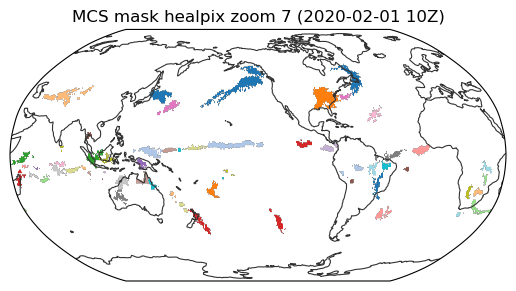

In [16]:
%%time

# Get HEALPix remap zoom level from config
hp_zoom = config.get("zarr_output_presets").get("healpix").get("zoom")

# Mask variable name
varname = 'mcs_mask'
# varname = 'ccs_mask'
tm = 10
t_str = ds.time.isel(time=tm).dt.strftime('%Y-%m-%d %HZ').item()

egh.healpix_show(ds[varname].isel(time=tm), cmap='tab20')
plt.title(f"MCS mask healpix zoom {hp_zoom} ({t_str})")

### Calculate MCS frequency over a period

In [17]:
# Get the start and end dates from the config
sdate = pd.to_datetime(config.get('startdate'), format='%Y%m%d.%H%M')
edate = pd.to_datetime(config.get('enddate'), format='%Y%m%d.%H%M')

# Sum the MCS mask over the time dimension
mcs_counts = (ds.mcs_mask.sel(time=slice(sdate, edate)) > 0).sum(dim='time')
# Divide by the number of time steps to get the frequency
ntimes = ds.time.sel(time=slice(sdate, edate)).sizes['time']
mcs_freq = mcs_counts / ntimes

CPU times: user 79.9 ms, sys: 4.62 ms, total: 84.5 ms
Wall time: 70.7 ms


<Figure size 640x480 with 0 Axes>

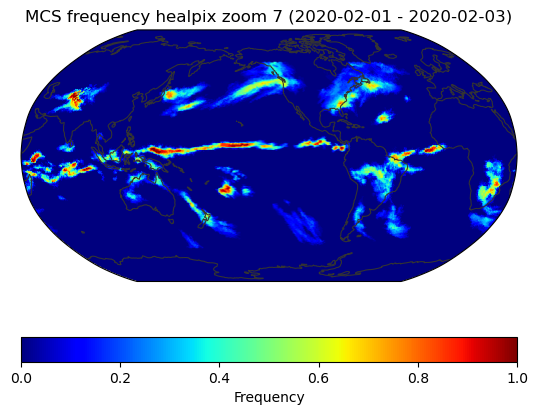

In [18]:
%%time

t_str = f"{sdate.strftime('%Y-%m-%d')} - {edate.strftime('%Y-%m-%d')}"

im = egh.healpix_show(mcs_freq, cmap='jet')
plt.title(f"MCS frequency healpix zoom {hp_zoom} ({t_str})")
plt.colorbar(im, label='Frequency', orientation='horizontal')

## Clean Up Resources
This step properly closes the Dask client if parallel processing was used.

In [19]:
# Clean up resources
if run_parallel >= 1:
    print("Shutting down Dask client...")
    client.close()
    print("Dask client shutdown complete.")

Shutting down Dask client...
Dask client shutdown complete.
